# GradCam

*Grad-CAM : Visual Explanations from Deep Networks via Gradientbased Localization*, R. Selvaraju et al. <br> In : International Conference on Computer Vision (ICCV 2017).

1. [Introduction](#Introduction)
2. [Discussion](#discuss)
3. [GuidedBackpropreLU](#GuidedBackpropReLU)

Ressources : 
 - https://github.com/jacobgil/pytorch-grad-cam (Github)
 
 - https://arxiv.org/pdf/1610.02391.pdf (Paper)
 
 - https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/



### <a id="Introduction"></a>Introduction

GradCam is a tool for interpretability of convolutional neural network aiming at spotlight parts of the image where the network *is paying attention*. The gradcam procedure is trying to bring transparency to the output of the CNN block of any neural network. Roughly speaking, it will measure the level of activation intensity the different part of the image will have when goiing through the different filters, with respect to a prediction. To do so, it builds a mask, commonly ploted as a heatmap, following the following procedure : 

   1. Compute the gradient of $y^c$ (before the softmax activation) w.r.t the *feature map* activation $A^k$of the convolutional part of the network, ie : $\frac{\partial y_c}{\partial A^k}$. This is obtained via backpropagation
   
   2. then, compute the importance weight $\alpha_k^c$ wrt to the $k^{th}$ channel, using global average pooling :
   
   $$ \alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}$$
   
   It capture the *importance* of the feature map *k* for the target classe *c*.
   
   3. finally, compute the weigthed (using $\alpha_k^c$) combinaison of a forward activation through the filters from the feature map and apply a ReLU operation so as to keep only positive influences :
   
   $$L_{\mbox{GradCam}}^c = ReLU( \sum_k \alpha_k^c A^k )$$
   
   The resulting vector is of the same size as the convolutional feature map A. One can at last obtain a heatmap by resizing the vector to match the input size.
   


**Packages**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import os
import pickle
import warnings
import numpy as np
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

### GradCam : step by step 


Makes it clearer to introduce a *model* class that seperates the features extraction from the classifier. This part might need to be modified though.

In [2]:
class model(nn.Module):
    def __init__(self, net):
        super(model, self).__init__()
        
        class Features(nn.Module):
            def __init__(self, conv):
                super(Features, self).__init__()
                self.features = conv
                
            def forward(self, x):
                fx = x.float() / 256
                conv_out = self.features(fx).view(fx.size()[0], -1)
                return conv_out
        
        self.features = Features(net.conv)
        self.classifier = net.fc

    def forward(self, x):
        conv_out = self.features(x)
        return self.classifier(conv_out)

**Load your own model**. Here we are going to use a DQN trained on Pong.

In [3]:
import sys
sys.path.append('C:/Users/damie/Desktop/XRL/Code/Algorithms/dqn-extensions')
import dqn_model, common

PATH_TO_PONG_MODEL = os.path.join('C:/Users/damie/Desktop/XRL/Code/Models', 'DQN/PongNoFrameskip-v4-best.dat')

ACT_SPACE = 6
OBS_SPACE = (4, 84, 84)

net = dqn_model.DQN(OBS_SPACE, ACT_SPACE)
net.load_state_dict(torch.load(PATH_TO_PONG_MODEL, map_location=lambda storage, loc: storage))
net = model(net)
print('Model Loaded')

Model Loaded


In this exemple, we've loaded the following model : 

    model(
      (features): Features(
        (features): Sequential(
          (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
        )
      )
      (classifier): Sequential(
        (0): Linear(in_features=3136, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=6, bias=True)
      )
    )

We are interested in the last feature map activations, ie the output of the last convolution, which is composed of **64** channels of size **(7,7)**.

((((84-8)/4+1)-4)/2+1-3)/1+1 = 7

**Load an observation**

Observation Shape :  torch.Size([1, 4, 84, 84])


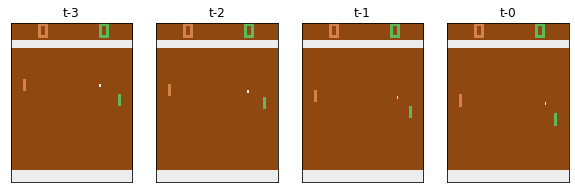

In [4]:
DIR_PATH = "C:/Users/damie/Desktop/XRL/Code/LIME/samples"
obs, last_4_frames, last_4_actions  = pickle.load(open(os.path.join(DIR_PATH, "sample_5.p"), "rb" ))
print("Observation Shape : ", obs.shape)

fig, ax = plt.subplots(1,4,figsize=(10,5))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
for i in range(4):
    ax[i].imshow(last_4_frames[i]) ; ax[i].set_title('t-{}'.format(3-i))

In [5]:
from gradcam import ModelOutputs

**1. Compute $\frac{\partial y_c}{\partial A^k}$ via backpropagation.**. 

Here, *A* is the last comvolutional feature map of the DQN, with K = 64, and $y^c$ is the value (before softmax) of the *action c*

Size of A : torch.Size([1, 64, 7, 7]) 
Output vector :  [[ -52.048706   38.458      28.415443  -81.4323   -138.06064   -30.238165]]


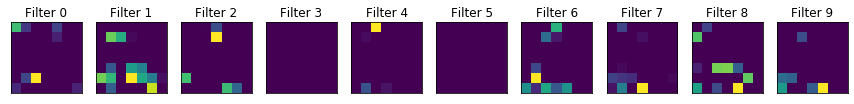

In [6]:
input = obs.float()
extractor = ModelOutputs(model=net,  target_layers=['features'])
features, output = extractor(input)

print('Size of A :', features[0].shape, '\nOutput vector : ', output.detach().numpy())

fig, ax = plt.subplots(1,10,figsize=(15,5))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
for i in range(10):
    ax[i].imshow(features[0][0,i].detach()) ; ax[i].set_title('Filter {}'.format(i))

**Select the action you're interested in**. If None, it uses the highest scoring category.

In [7]:
index = None
if index == None:
    index = np.argmax(output.cpu().data.numpy())
    print('Highest score for action :', index)

Highest score for action : 1


Prepare the backpropagation w.r.t the corresponding index

In [8]:
one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
one_hot[0][index] = 1
one_hot = torch.from_numpy(one_hot).requires_grad_(True)

one_hot = torch.sum(one_hot * output)
one_hot

tensor(38.4580, grad_fn=<SumBackward0>)

Compute the **backpropagation** after making sure to set all gradients to zero.

In [9]:
net.features.zero_grad()
net.classifier.zero_grad()

one_hot.backward(retain_graph=True)

Get the gradient from the feature map activation A

In [10]:
grads_val = extractor.get_gradients()[-1].cpu().data.numpy()
grads_val.shape

(1, 64, 7, 7)

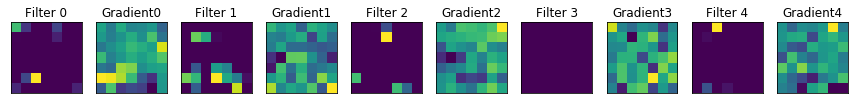

In [11]:
fig, ax = plt.subplots(1,10,figsize=(15,5))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
for i in range(10):
    if i%2 :
        ax[i].imshow(grads_val[0,i//2]) ; ax[i].set_title('Gradient{}'.format(i//2))
    else : 
        ax[i].imshow(features[0][0,i//2].detach()) ; ax[i].set_title('Filter {}'.format(i//2))

**2. Compite the *importance* weigths** using global average pooling, ie mean on height and width.

In [12]:
target = features[-1]
target = target.cpu().data.numpy()[0, :]

weights = np.mean(grads_val, axis=(2, 3))[0, :]

**3. Compute the weighted combinaison of feature maps**. The output size is then a 7x7 grid.

(7, 7)

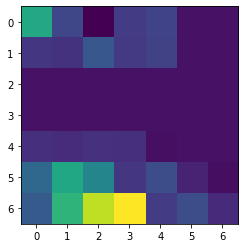

In [13]:
cam = np.zeros(target.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * target[i, :, :]
    
plt.imshow(cam) ; cam.shape

Text(0.5, 1.0, 'Negative influence')

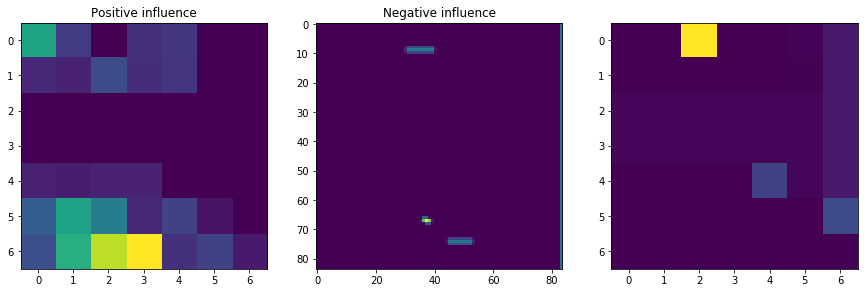

In [14]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(np.maximum(cam,0)) ; ax[0].set_title('Positive influence')
ax[1].imshow(obs[0,3]) ; ax[0].set_title('Positive influence')
ax[2].imshow(-np.minimum(cam,0)) ; ax[1].set_title('Negative influence')


**Get Saliency Map**

In [15]:
from skimage.transform import resize

def saliency_on_atari_frame(saliency, atari, fudge_factor, channel=2, sigma=0, size = [84,84]):
    pmax = saliency.max()
    S = resize(saliency, output_shape=size,  mode='wrap').astype(np.float32)
    S = S**2
    S = S if sigma == 0 else gaussian_filter(S, sigma=sigma)
    S -= S.min() ; S = fudge_factor * 255 * S / S.max()
    I = atari.astype('uint16')
    I[:,:,channel] += S.astype('uint16')
    I = I.clip(1,255).astype('uint8')
    return I

def process_mask(mask):
    overlay_mask = np.zeros((210,160), 'uint8')
    overlay_mask[35:195,:] = resize(np.swapaxes(mask,1,0), output_shape = (160,160)).astype('uint8')
    #overlay_orig = cv2.addWeighted(overlay_orig, 0.5,orig_img, 1, 0)
    return overlay_mask

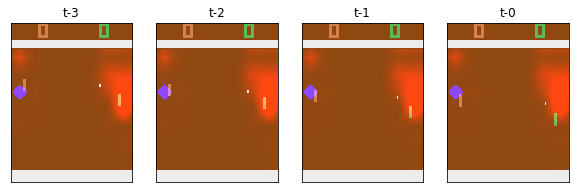

In [16]:
mask_pos, mask_neg = process_mask(np.maximum(cam, 0)), process_mask(-np.minimum(cam, 0))
fig, ax = plt.subplots(1,4,figsize=(10,5))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
for i in range(4):
    ax[i].imshow(last_4_frames[i]) ; ax[i].set_title('t-{}'.format(3-i))
    sal_pos = saliency_on_atari_frame(mask_pos, last_4_frames[i], fudge_factor = 1, channel = 0,sigma = 0, size = [210,160])
    sal_final = saliency_on_atari_frame(mask_neg,sal_pos, fudge_factor = 1, channel = 2,sigma = 0,  size = [210,160])
    ax[i].imshow(sal_final) ; ax[i].set_title('t-{}'.format(3-i))

**Remarks** : ....

### <a id="GuidedBackpropReLU"></a>GuidedBackpropReLU

In [17]:
class GuidedBackpropReLU(Function):

    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input),
                                   torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply
                
        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output

In [18]:
def recursive_relu_apply(module_top):
    for idx, module in module_top._modules.items():
        print(idx, module)
        recursive_relu_apply(module)
        if module.__class__.__name__ == 'ReLU':
            module_top._modules[idx] = GuidedBackpropReLU.apply


In [19]:
net = dqn_model.DQN(OBS_SPACE, ACT_SPACE)
net.load_state_dict(torch.load(PATH_TO_PONG_MODEL, map_location=lambda storage, loc: storage))
net.conv.zero_grad()
net.fc.zero_grad()

net.eval()
recursive_relu_apply(net)
net

conv Sequential(
  (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
)
0 Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
1 ReLU()
2 Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
3 ReLU()
4 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
5 ReLU()
fc Sequential(
  (0): Linear(in_features=3136, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=6, bias=True)
)
0 Linear(in_features=3136, out_features=512, bias=True)
1 ReLU()
2 Linear(in_features=512, out_features=6, bias=True)


DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): <built-in method apply of FunctionMeta object at 0x000001F76A5DC7F8>
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): <built-in method apply of FunctionMeta object at 0x000001F76A5DC7F8>
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): <built-in method apply of FunctionMeta object at 0x000001F76A5DC7F8>
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): <built-in method apply of FunctionMeta object at 0x000001F76A5DC7F8>
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [20]:
target_index = None
index = None

input = obs.float().requires_grad_(True)
output = net(input)

if index == None:
    index = np.argmax(output.cpu().data.numpy())

print('Index :', index, 'Output :', output.cpu().data.numpy())

one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
one_hot[0][index] = 1
one_hot = torch.from_numpy(one_hot).requires_grad_(True)
one_hot = torch.sum(one_hot * output)

one_hot.backward(retain_graph=True)
output = input.grad.cpu().data.numpy()
output = output[0, :, :, :]

Index : 2 Output : [[ 0.16826548  0.42834806  0.5685358   0.19444427 -0.06415313  0.3802368 ]]


In [22]:
cam_pos = np.maximum(cam, 0)
cam_pos = resize(cam_pos, output_shape=(84,84),  mode='wrap').astype(np.float32) #INTER_LINEAR #INTER_AREA 
cam_pos = cam_pos**2
cam_pos = cam_pos - np.min(cam_pos)
cam_pos = cam_pos / np.max(cam_pos)

In [23]:
gb = output.transpose((1, 2, 0))

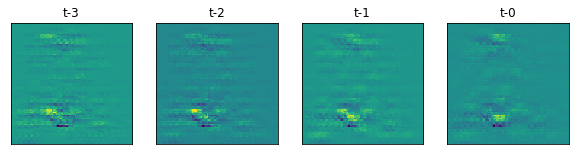

In [24]:
fig, ax = plt.subplots(1,4,figsize=(10,5))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
for i in range(4):
    ax[i].imshow(output[i]) ; ax[i].set_title('t-{}'.format(3-i))

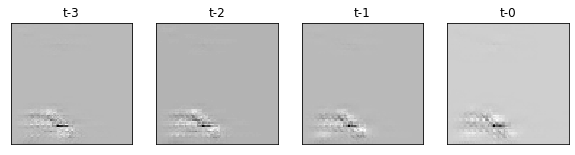

In [25]:
fig, ax = plt.subplots(1,4,figsize=(10,5))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
for i in range(4):
    ax[i].imshow(cam_pos*output[i],  cmap = 'gray' ) ; ax[i].set_title('t-{}'.format(3-i))

______________________________________________________